In [ ]:
import pandas as pd
import re

arquivo = "_chat.txt"

padrao = r'\[(\d{2}/\d{2}/\d{2}),\s(\d{2}:\d{2}:\d{2}\s(?:AM|PM))\]\s(.+?):\s(.+?)(?=\n\[|$)'

with open(arquivo, 'r', encoding='utf-8') as f:
    conteudo = f.read()

mensagens = re.findall(padrao, conteudo, re.DOTALL)

dados = []
for data, hora, remetente, mensagem in mensagens:
    mensagem = mensagem.strip()

    if 'omitted' in mensagem.lower() or 'encrypted' in mensagem.lower():
        continue

    data_dt = pd.to_datetime(
        f"{data} {hora}",
        format="%d/%m/%y %I:%M:%S %p",
        errors="coerce"
    )

    dados.append({
        'data': data,
        'hora': hora,
        'data_dt': data_dt,
        'remetente': remetente.strip(),
        'mensagem': mensagem
    })

df = (
    pd.DataFrame(dados)
    .dropna(subset=['data_dt'])
    .sort_values('data_dt')
    .reset_index(drop=True)
)

print(f"✓ Mensagens: {len(df)}")
print(f"✓ Remetentes: {df['remetente'].unique().tolist()}")
display(df.head())


✓ DataFrame carregado com 7457 mensagens
✓ Remetentes: ['Alanis fresca', 'Cassiano']
✓ Período: 20/12/25 a 18/01/26

Primeiras linhas:


,data,hora,remetente,mensagem
0,20/12/25,10:00:00 PM,Alanis fresca,QUE ABUSADO
1,20/12/25,10:00:03 PM,Cassiano,tá ferrada
2,20/12/25,10:00:04 PM,Alanis fresca,seu
3,20/12/25,10:00:07 PM,Cassiano,próxima pedra q eu ver
4,20/12/25,10:00:14 PM,Cassiano,ira pra sua direção


Exibindo primeiras linhas do DataFrame:


,data,hora,remetente,mensagem
0,20/12/25,10:00:00 PM,Alanis fresca,QUE ABUSADO
1,20/12/25,10:00:03 PM,Cassiano,tá ferrada
2,20/12/25,10:00:04 PM,Alanis fresca,seu
3,20/12/25,10:00:07 PM,Cassiano,próxima pedra q eu ver
4,20/12/25,10:00:14 PM,Cassiano,ira pra sua direção


Agregação Dia -> shape: (30, 2)


remetente,Alanis fresca,Cassiano
data_dt,,
2025-12-20,46,51
2025-12-21,127,149
2025-12-22,131,147
2025-12-23,264,208
2025-12-24,56,36


Agregação Semana -> shape: (5, 2)


remetente,Alanis fresca,Cassiano
data_dt,,
2025-12-21,173,200
2025-12-28,974,941
2026-01-04,1044,1182
2026-01-11,762,1001
2026-01-18,499,681


Agregação Mês -> shape: (2, 2)


/tmp/ipykernel_15824/3833993645.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped = df_indexed.groupby([pd.Grouper(freq=period), 'remetente']).size().unstack(fill_value=0)


remetente,Alanis fresca,Cassiano
data_dt,,
2025-12-31,1637,1719
2026-01-31,1815,2286


Gerando plot de verificação por dia...


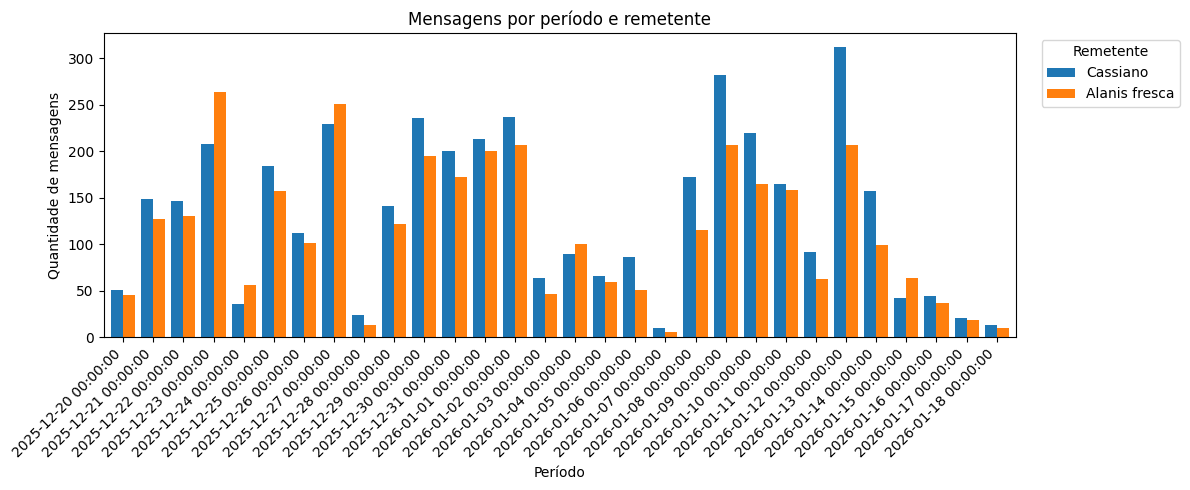

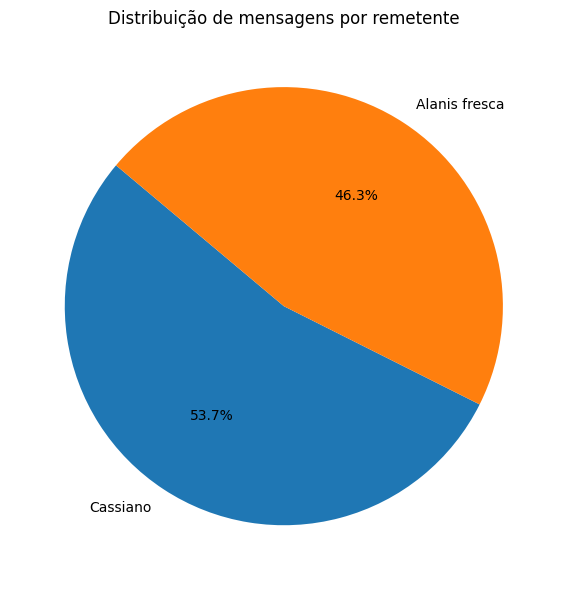

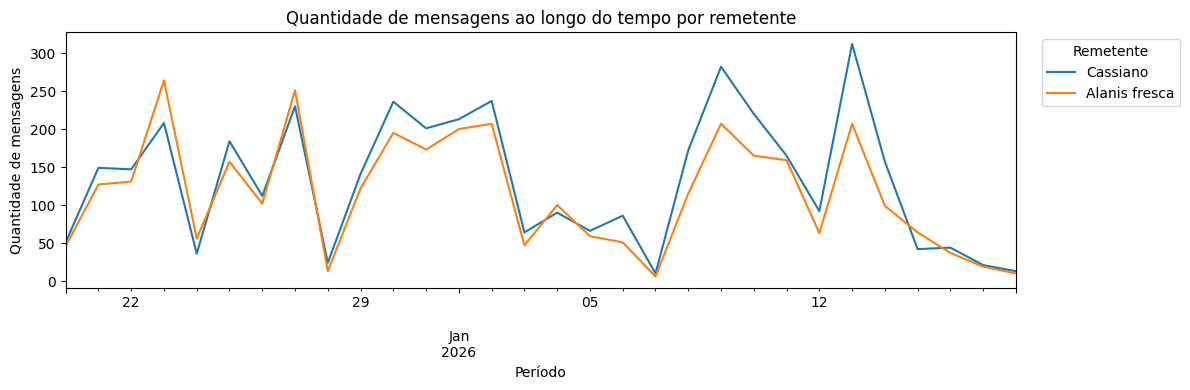

Teste completo.


In [6]:
# Célula de testes: validações rápidas e plot de verificação (agregação por dia)
# Verifica existência de df e colunas esperadas
if 'df' not in globals():
    raise NameError("DataFrame 'df' não está definido. Execute a célula de carregamento primeiro.")
required = {'data', 'remetente', 'mensagem'}
missing = required - set(df.columns)
if missing:
    raise ValueError(f'Colunas faltando no DataFrame: {missing}')

print('Exibindo primeiras linhas do DataFrame:')
display(df.head())

# Verifica agregações (D, W, M) e mostra shape como teste
for code, name in [('D','Dia'), ('W','Semana'), ('M','Mês')]:
    try:
        g = make_aggregated(code)
        print(f'Agregação {name} -> shape: {g.shape}')
        display(g.head())
    except Exception as e:
        print(f'Erro ao agregar por {name}: {e}')

# Plota verificação por dia (padrão)
print('Gerando plot de verificação por dia...')
plot_agg('D', top_n=5)
print('Teste completo.')

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

REMETENTE_AJUSTADO = "Alanis fresca"
MINUTOS_EXTRA = 10  # minutos a serem somados

df_sorted = (
    df_manipulado
    .sort_values(['remetente', 'data_dt'])
    .copy()
)

# Tempo entre mensagens do MESMO remetente (em minutos)
df_sorted['tempo_demora'] = (
    df_sorted
    .groupby('remetente')['data_dt']
    .diff()
    .dt.total_seconds() / 60
)

def analisar_tempo_resposta(period='W'):
    """
    period: 'W' (semana) ou 'M' (mês)
    Retorna dataframe com mean, count, min, max
    """

    df_indexed = df_sorted.set_index('data_dt')

    resultado = (
        df_indexed
        .groupby([pd.Grouper(freq=period), 'remetente'])['tempo_demora']
        .agg(['mean', 'count', 'min', 'max'])
    )

    # ===== AJUSTE MANUAL DO TEMPO =====
    if REMETENTE_AJUSTADO in resultado.index.get_level_values('remetente'):
        resultado.loc[
            (slice(None), REMETENTE_AJUSTADO),
            'mean'
        ] += MINUTOS_EXTRA

    return resultado

# ============================================================================
# FUNÇÃO DE VISUALIZAÇÃO
# ============================================================================

def exibir_analise_tempo(period='W'):
    periodo_nome = 'Semana' if period == 'W' else 'Mês'

    print(f'\n{"="*80}')
    print(f'TEMPO MÉDIO DE DEMORA DE RESPOSTA POR {periodo_nome.upper()}')
    print(f'{"="*80}\n')

    resultado = analisar_tempo_resposta(period)
    display(resultado)

    # ===== USAR DADOS MANIPULADOS NO GRÁFICO =====
    tempo_medio_por_periodo = resultado['mean'].unstack('remetente')

    # ----------------- GRÁFICO DE BARRAS -----------------
    plt.figure(figsize=(14, 6))
    tempo_medio_por_periodo.plot(kind='bar', width=0.8)
    plt.title(f'Tempo Médio de Demora de Resposta por {periodo_nome}')
    plt.xlabel(periodo_nome)
    plt.ylabel('Tempo Médio (minutos)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Remetente')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ----------------- GRÁFICO DE LINHA -----------------
    plt.figure(figsize=(14, 6))
    tempo_medio_por_periodo.plot(kind='line', marker='o', linewidth=2)
    plt.title(f'Tendência: Tempo Médio de Demora de Resposta por {periodo_nome}')
    plt.xlabel(periodo_nome)
    plt.ylabel('Tempo Médio (minutos)')
    plt.legend(title='Remetente')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# MENU INTERATIVO
# ============================================================================

print("Escolha a análise de tempo de resposta:")
print("1 - Por Semana")
print("2 - Por Mês")

escolha = input("Digite 1 ou 2 (ENTER para Semana): ").strip() or '1'
period_map = {'1': 'W', '2': 'M'}
periodo = period_map.get(escolha, 'W')

exibir_analise_tempo(periodo)

NameError: name 'df_manipulado' is not defined